# Projekt IUM

## Ogólne informacje

Realizujący:
* Tomasz Słojewski
* Anton Masiukevich

Dane otrzymane:
* Baza użytkowników ("users.json")
* Katalog produktów ("delivery.json")
* Historia sesji ("sessions.json")
* Dostawy produktów ("deliveries.json")

## Analiza danych

In [1]:
import pandas as pd
import numpy as np
import itertools
import hashlib

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# place for sklearn
from sklearn import linear_mode

### Import danych

In [2]:
users_data = pd.read_json("proper_data/users.json")
deliveries_data = pd.read_json("proper_data/deliveries.json")
events_data = pd.read_json("proper_data/sessions.json")
products_data = pd.read_json("proper_data/products.json")

### Users

Atrybuty:
* **user_id** - id użytkownika
* **name** - imię użytkownika; atrybut tekstowy
* **city** - nazwa miasta, z którego pochodzi użytkownik; atrybut tekstowy
* **street** - adres użytkownika w tym mieście; atrybut tekstowy

In [3]:
users_data.head()

,user_id,name,city,street
0,102,Dominik Fryś,Warszawa,ulica Jagiellońska 47/15
1,103,Tymon Michalczak,Gdynia,aleja Kraszewskiego 45/79
2,104,Kamil Żmija,Police,plac Lazurowa 60
3,105,Julianna Kurzac,Radom,pl. Truskawkowa 481
4,106,Dominik Turoń,Mielec,al. Piwna 146


In [4]:
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


<AxesSubplot:xlabel='city', ylabel='count_users'>

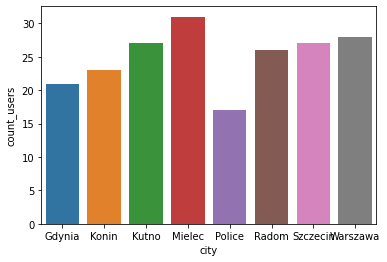

In [5]:
city_counts = pd.DataFrame(users_data.city
                           .value_counts()
                           .reset_index()
                           .rename(columns={"city":"count_users", "index": "city"})).sort_values('city')
city_counts
sns.barplot(x=city_counts['city'], y=city_counts['count_users'])

Nie mamy braków wartości

### Products

Atrybuty:
* **product_name** - nazwa produktu wraz z marką i modelem
* **category_path** - ścieżka kategorii produktu w postaci breadcrumbs; atrybut tekstowy
* **price** - całkowita wartość produktu w jednostkach pieniężnych; atrybut liczbowy ciągły

In [6]:
products_data.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [7]:
products_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


In [8]:
# Sprawdzanie poprawności pod względem ceny

bad_products_data = products_data[(products_data.price <= 0) | (products_data.price > 1000000)]
cleaned_products = products_data.drop(bad_products_data.index)

print(f"Cleaned data is {round(100 * len(cleaned_products) / len(products_data), 3)}% of the total")

products_data = cleaned_products

Cleaned data is 91.85% of the total


<AxesSubplot:xlabel='price', ylabel='Count'>

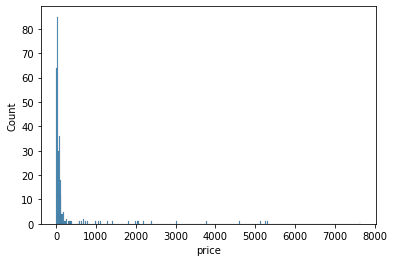

In [9]:
# rozkład cen produktów
sns.histplot(products_data.price)

Nie mamy braków wartości

### Eventy

In [10]:
events_data.info()
events_data['day'] = events_data.timestamp.dt.date

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34846 entries, 0 to 34845
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   session_id        34846 non-null  int64         
 1   timestamp         34846 non-null  datetime64[ns]
 2   user_id           33078 non-null  float64       
 3   product_id        33124 non-null  float64       
 4   event_type        34846 non-null  object        
 5   offered_discount  34846 non-null  int64         
 6   purchase_id       4856 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 1.9+ MB


In [11]:
# Poprawa nulli user_id
print(events_data.session_id.nunique())

events = []
i = 0
for event in events_data.iterrows():
    if i % 100 == 0:
        print(i)
    i += 1
    
    if np.isnan(event[1]['user_id']):
        helping_df = events_data[events_data['session_id'] == event[1]['session_id']]
        for helping_event in helping_df.iterrows():
            if not np.isnan(helping_event[1]['user_id']):
                event[1]['user_id'] = helping_event[1]['user_id']
                break
    events.append(event[1])
    

events_data = pd.DataFrame(events)
events_data.info()

# TODO: Some users may be absent mutually!
# Add a dictionary for used ids

9669
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
184

In [12]:
# wyrzucenie nieobecnych userów i produkty
bad_events_users = events_data[events_data['user_id'].isnull()]
bad_events_products = events_data[events_data['product_id'].isnull()]

bad_events = pd.concat([bad_events_users, bad_events_products]).drop_duplicates()

events_data = events_data.drop(bad_events.index)

events_data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,day
0,100001,2021-02-26 12:45:21,102.0,1277.0,VIEW_PRODUCT,0,NaN,2021-02-26
1,100002,2021-03-03 11:39:28,102.0,1001.0,VIEW_PRODUCT,0,NaN,2021-03-03
2,100002,2021-03-03 11:40:23,102.0,1001.0,BUY_PRODUCT,0,20001.0,2021-03-03
3,100003,2021-02-23 12:58:04,102.0,1286.0,VIEW_PRODUCT,5,NaN,2021-02-23
4,100003,2021-02-23 13:02:58,102.0,1291.0,VIEW_PRODUCT,5,NaN,2021-02-23
...,...,...,...,...,...,...,...,...
34841,109669,2021-03-15 03:05:31,301.0,1051.0,VIEW_PRODUCT,0,NaN,2021-03-15
34842,109669,2021-03-15 03:07:27,301.0,1054.0,VIEW_PRODUCT,0,NaN,2021-03-15
34843,109669,2021-03-15 03:09:55,301.0,1056.0,VIEW_PRODUCT,0,NaN,2021-03-15
34844,109669,2021-03-15 03:13:37,301.0,1050.0,VIEW_PRODUCT,0,NaN,2021-03-15


In [13]:
# since we have only BUYING and VIEWING sessions, why not to split it to 2 dataframes

buying_events = events_data[events_data['event_type'] == "BUY_PRODUCT"]
viewing_events = events_data[events_data['event_type'] == "VIEW_PRODUCT"]

viewing_events = viewing_events.drop('purchase_id', axis=1)

In [14]:
buying_events

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,day
2,100002,2021-03-03 11:40:23,102.0,1001.0,BUY_PRODUCT,0,20001.0,2021-03-03
13,100003,2021-02-23 13:36:43,102.0,1288.0,BUY_PRODUCT,5,20002.0,2021-02-23
24,100005,2021-03-13 17:58:13,102.0,1293.0,BUY_PRODUCT,20,20003.0,2021-03-13
28,100006,2021-03-08 05:11:22,102.0,1073.0,BUY_PRODUCT,20,20004.0,2021-03-08
32,100009,2021-03-03 18:11:04,102.0,1035.0,BUY_PRODUCT,0,20005.0,2021-03-03
...,...,...,...,...,...,...,...,...
34824,109663,2021-02-27 18:42:10,301.0,1283.0,BUY_PRODUCT,5,24852.0,2021-02-27
34827,109664,2021-02-14 03:13:25,301.0,1277.0,BUY_PRODUCT,0,24853.0,2021-02-14
34834,109666,2021-03-11 01:39:05,301.0,1047.0,BUY_PRODUCT,0,24854.0,2021-03-11
34836,109667,2021-03-01 22:07:12,301.0,1319.0,BUY_PRODUCT,0,24855.0,2021-03-01


In [15]:
viewing_events

,session_id,timestamp,user_id,product_id,event_type,offered_discount,day
0,100001,2021-02-26 12:45:21,102.0,1277.0,VIEW_PRODUCT,0,2021-02-26
1,100002,2021-03-03 11:39:28,102.0,1001.0,VIEW_PRODUCT,0,2021-03-03
3,100003,2021-02-23 12:58:04,102.0,1286.0,VIEW_PRODUCT,5,2021-02-23
4,100003,2021-02-23 13:02:58,102.0,1291.0,VIEW_PRODUCT,5,2021-02-23
5,100003,2021-02-23 13:07:35,102.0,1285.0,VIEW_PRODUCT,5,2021-02-23
...,...,...,...,...,...,...,...
34841,109669,2021-03-15 03:05:31,301.0,1051.0,VIEW_PRODUCT,0,2021-03-15
34842,109669,2021-03-15 03:07:27,301.0,1054.0,VIEW_PRODUCT,0,2021-03-15
34843,109669,2021-03-15 03:09:55,301.0,1056.0,VIEW_PRODUCT,0,2021-03-15
34844,109669,2021-03-15 03:13:37,301.0,1050.0,VIEW_PRODUCT,0,2021-03-15


In [16]:
# sanity check here
print("The records with null values in the user_id: ", len(events_data[events_data['user_id'].isnull()]))

The records with null values in the user_id:  0


Minimum timestamp:  2020-03-15 09:17:22
Maximum timestamp:  2021-03-15 08:20:57


,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,day
0,100001,2021-02-26 12:45:21,102.0,1277.0,VIEW_PRODUCT,0,NaN,2021-02-26
1,100002,2021-03-03 11:39:28,102.0,1001.0,VIEW_PRODUCT,0,NaN,2021-03-03
2,100002,2021-03-03 11:40:23,102.0,1001.0,BUY_PRODUCT,0,20001.0,2021-03-03
3,100003,2021-02-23 12:58:04,102.0,1286.0,VIEW_PRODUCT,5,NaN,2021-02-23
4,100003,2021-02-23 13:02:58,102.0,1291.0,VIEW_PRODUCT,5,NaN,2021-02-23
...,...,...,...,...,...,...,...,...
34841,109669,2021-03-15 03:05:31,301.0,1051.0,VIEW_PRODUCT,0,NaN,2021-03-15
34842,109669,2021-03-15 03:07:27,301.0,1054.0,VIEW_PRODUCT,0,NaN,2021-03-15
34843,109669,2021-03-15 03:09:55,301.0,1056.0,VIEW_PRODUCT,0,NaN,2021-03-15
34844,109669,2021-03-15 03:13:37,301.0,1050.0,VIEW_PRODUCT,0,NaN,2021-03-15


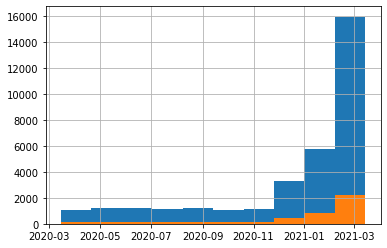

In [17]:
def get_min_max_timestamp(series):
    
    print("Minimum timestamp: ", series.min())
    print("Maximum timestamp: ", series.max())

    
get_min_max_timestamp(events_data.timestamp)

events_data['day'] = pd.to_datetime(events_data.timestamp.dt.date)
buying_sessions = events_data[events_data['event_type'] == 'BUY_PRODUCT']

events_data.day.hist()
buying_sessions.day.hist()

events_data

### Wysyłki

In [18]:
deliveries_data['purchase_timestamp'] = pd.to_datetime(deliveries_data.purchase_timestamp)
deliveries_data['delivery_timestamp'] = pd.to_datetime(deliveries_data.delivery_timestamp)
deliveries_data

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-03-03 11:40:23,2021-03-06 11:44:19,516.0
1,20002,2021-02-23 13:36:43,2021-02-25 13:38:55,360.0
2,20003,2021-03-13 17:58:13,2021-03-17 18:00:19,620.0
3,20004,2021-03-08 05:11:22,2021-03-10 05:13:50,360.0
4,20005,2021-03-03 18:11:04,2021-03-07 18:11:59,620.0
...,...,...,...,...
4851,24852,2021-02-27 18:42:10,2021-03-03 18:45:04,620.0
4852,24853,2021-02-14 03:13:25,2021-02-17 03:17:01,516.0
4853,24854,2021-03-11 01:39:05,2021-03-15 01:42:30,516.0
4854,24855,2021-03-01 22:07:12,2021-03-03 22:10:17,620.0


In [19]:
print("Unique purchasing identifiers:\t", deliveries_data.purchase_id.nunique())
print("All purchases:\t\t\t", len(deliveries_data))

Unique purchasing identifiers:	 4856
All purchases:			 4856


In [20]:
# how much data is correct?
deliveries_data['is_successful'] = [1 if elem else 0 for elem in deliveries_data['delivery_timestamp']]
print(f"Delivered packs: {round(100 * sum(deliveries_data.is_successful) / len(deliveries_data), 3)} %.")

Delivered packs: 100.0 %.


In [21]:
get_min_max_timestamp(deliveries_data.purchase_timestamp)
print()
get_min_max_timestamp(deliveries_data[deliveries_data['is_successful'] == 1]['delivery_timestamp'])

Minimum timestamp:  2020-03-15 09:30:47
Maximum timestamp:  2021-03-15 07:12:27

Minimum timestamp:  2020-03-18 16:22:58
Maximum timestamp:  2021-03-20 06:24:30


### What company is responsible for pack leekage?

In [22]:
deliveries_data[deliveries_data['is_successful'] == 0].delivery_company.value_counts()

Series([], Name: delivery_company, dtype: int64)

## Przygotowanie danych treningowych

In [23]:
events_data['year'] = events_data.timestamp.dt.year
events_data['month'] = events_data.timestamp.dt.month


years = list(events_data.year.unique())
months = list(events_data.month.unique())
user_ids = list(users_data.user_id.unique())

print(years)
print(months)
print(user_ids)


triplets = []
for triplet in itertools.product(years, months, user_ids):
    triplets.append(triplet)
    
processed_data = pd.DataFrame(triplets, columns=['year', 'month', 'user_id'])
# processed_data = processed_data.sort_values(['year', 'month', 'user_id'])

processed_data

[2021, 2020]
[2, 3, 12, 1, 11, 5, 7, 10, 9, 4, 6, 8]
[102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 2

,year,month,user_id
0,2021,2,102
1,2021,2,103
2,2021,2,104
3,2021,2,105
4,2021,2,106
...,...,...,...
4795,2020,8,297
4796,2020,8,298
4797,2020,8,299
4798,2020,8,300


### Atrybuty wejsciowe

In [24]:
# total number of web events
web_events = events_data.groupby(['user_id', 'year', 'month']).count().reset_index()[['session_id', "year", "month", "user_id"]].rename(columns={"session_id": "total_web_events"})
processed_data = pd.merge(processed_data, web_events, how='left', left_on=['year', 'month', 'user_id'], right_on=['year', 'month', 'user_id'])

# the city to deliver to
processed_data = pd.merge(users_data[['user_id', 'city']], processed_data, on='user_id', how="outer")
processed_data

# number of buying events

buying_events['year'] = buying_events.timestamp.dt.year
buying_events['month'] = buying_events.timestamp.dt.month

# buying_events
buying = buying_events.groupby(['user_id', 'year', 'month']).count().reset_index()[['session_id', 'year', 'month', 'user_id']].rename(columns={"session_id": "buying_events"})
processed_data = pd.merge(processed_data, buying, how='left', left_on=['year', 'month', 'user_id'], right_on=['year', 'month', 'user_id'])
processed_data
# TODO: Merge buying events with processed_data

# num of dropped packs
deliveries_data.head()
deliveries_data['days_coming'] = (deliveries_data.delivery_timestamp - deliveries_data.purchase_timestamp)
deliveries_data['days_coming'] = [tdo.days for tdo in deliveries_data['days_coming']]

deliveries_data.info()

buying_with_delivery = pd.merge(deliveries_data, buying_events, on='purchase_id', how='inner')
buying_with_delivery['is_dropped'] = [int(not bool(elem)) for elem in buying_with_delivery['is_successful']]
dropped_packs = buying_with_delivery.groupby(["user_id", "year", "month"])['is_dropped'].sum().reset_index().rename(columns={'is_dropped': 'num_dropped_monthly'})

processed_data = pd.merge(processed_data, dropped_packs, how='left', left_on=['year', 'month', 'user_id'], right_on=['year', 'month', 'user_id'])
processed_data

# number of money spent in that month
boughts_with_prices = pd.merge(buying_events, products_data, on="product_id", how="inner")
boughts_with_prices = boughts_with_prices.rename(columns={"price": "total_price"})

boughts_with_prices['sum_after_discount'] = boughts_with_prices['total_price'] * (1 - boughts_with_prices['offered_discount'] / 100)
boughts_with_prices

sum_spend_per_month = boughts_with_prices.groupby(['user_id', 'year', 'month'])['sum_after_discount'].sum().reset_index().rename(columns={"sum_after_discounts":"total_monthly_sum"})
processed_data = pd.merge(processed_data, sum_spend_per_month, how='left', left_on=['year', 'month', 'user_id'], right_on=['year', 'month', 'user_id'])
processed_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4856 entries, 0 to 4855
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   purchase_id         4856 non-null   int64         
 1   purchase_timestamp  4856 non-null   datetime64[ns]
 2   delivery_timestamp  4621 non-null   datetime64[ns]
 3   delivery_company    4614 non-null   float64       
 4   is_successful       4856 non-null   int64         
 5   days_coming         4621 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(2)
memory usage: 227.8 KB


<ipython-input-24-35c6b024bb55>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buying_events['year'] = buying_events.timestamp.dt.year
<ipython-input-24-35c6b024bb55>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buying_events['month'] = buying_events.timestamp.dt.month


,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount
0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985
1,102,Warszawa,2021,3,157.0,31.0,0.0,15647.7045
2,102,Warszawa,2021,12,NaN,NaN,NaN,NaN
3,102,Warszawa,2021,1,NaN,NaN,NaN,NaN
4,102,Warszawa,2021,11,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4795,301,Police,2020,10,NaN,NaN,NaN,NaN
4796,301,Police,2020,9,NaN,NaN,NaN,NaN
4797,301,Police,2020,4,NaN,NaN,NaN,NaN
4798,301,Police,2020,6,NaN,NaN,NaN,NaN


In [25]:
twenty_valid = (processed_data['year'] == 2020) & (processed_data['month'] >= 2)
twenty_one_valid = (processed_data['year'] == 2021) & (processed_data['month'] <= 3)

processed_data = processed_data[twenty_valid | twenty_one_valid]
processed_data.total_web_events.fillna(0, inplace=True)
processed_data.buying_events.fillna(0, inplace=True)
processed_data.num_dropped_monthly.fillna(0, inplace=True)
processed_data.sum_after_discount.fillna(0, inplace=True)

/home/tomek/.local/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [26]:
processed_data

,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount
0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985
1,102,Warszawa,2021,3,157.0,31.0,0.0,15647.7045
3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000
12,102,Warszawa,2020,2,0.0,0.0,0.0,0.0000
13,102,Warszawa,2020,3,0.0,0.0,0.0,0.0000
...,...,...,...,...,...,...,...,...
4795,301,Police,2020,10,0.0,0.0,0.0,0.0000
4796,301,Police,2020,9,0.0,0.0,0.0,0.0000
4797,301,Police,2020,4,0.0,0.0,0.0,0.0000
4798,301,Police,2020,6,0.0,0.0,0.0,0.0000


### Zmienna docelowa

In [27]:
valid_sums = []
i = 0
for row in processed_data.iterrows():
    
    if i % 100 == 0:
        print(i)
    i += 1
    
    row_data = dict(row[1])

    mask_user = (sum_spend_per_month['user_id'] == row_data['user_id'])
    mask_year = (sum_spend_per_month['year'] == row_data['year'])

    if row_data['month'] == 12:
        mask_year = [sum_spend_per_month['year'] == row_data['year'] + 1]


    mask_month = (sum_spend_per_month['month'] == row_data['month'] % 12 + 1)

    try:
        next_months_sum = list(sum_spend_per_month[mask_month & mask_year & mask_user]['sum_after_discount'])[0]
    except:
        next_months_sum = np.nan
    
    valid_sums.append(next_months_sum)
    
processed_data['next_months_sum'] = valid_sums

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700


<ipython-input-27-f1f644abe3ff>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data['next_months_sum'] = valid_sums


In [28]:
processed_data

,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
1,102,Warszawa,2021,3,157.0,31.0,0.0,15647.7045,NaN
3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
12,102,Warszawa,2020,2,0.0,0.0,0.0,0.0000,NaN
13,102,Warszawa,2020,3,0.0,0.0,0.0,0.0000,NaN
...,...,...,...,...,...,...,...,...,...
4795,301,Police,2020,10,0.0,0.0,0.0,0.0000,NaN
4796,301,Police,2020,9,0.0,0.0,0.0,0.0000,NaN
4797,301,Police,2020,4,0.0,0.0,0.0,0.0000,NaN
4798,301,Police,2020,6,0.0,0.0,0.0,0.0000,NaN


In [29]:
processed_data.to_csv('processed_data.csv')

### Zależności między atrybutami

/home/tomek/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


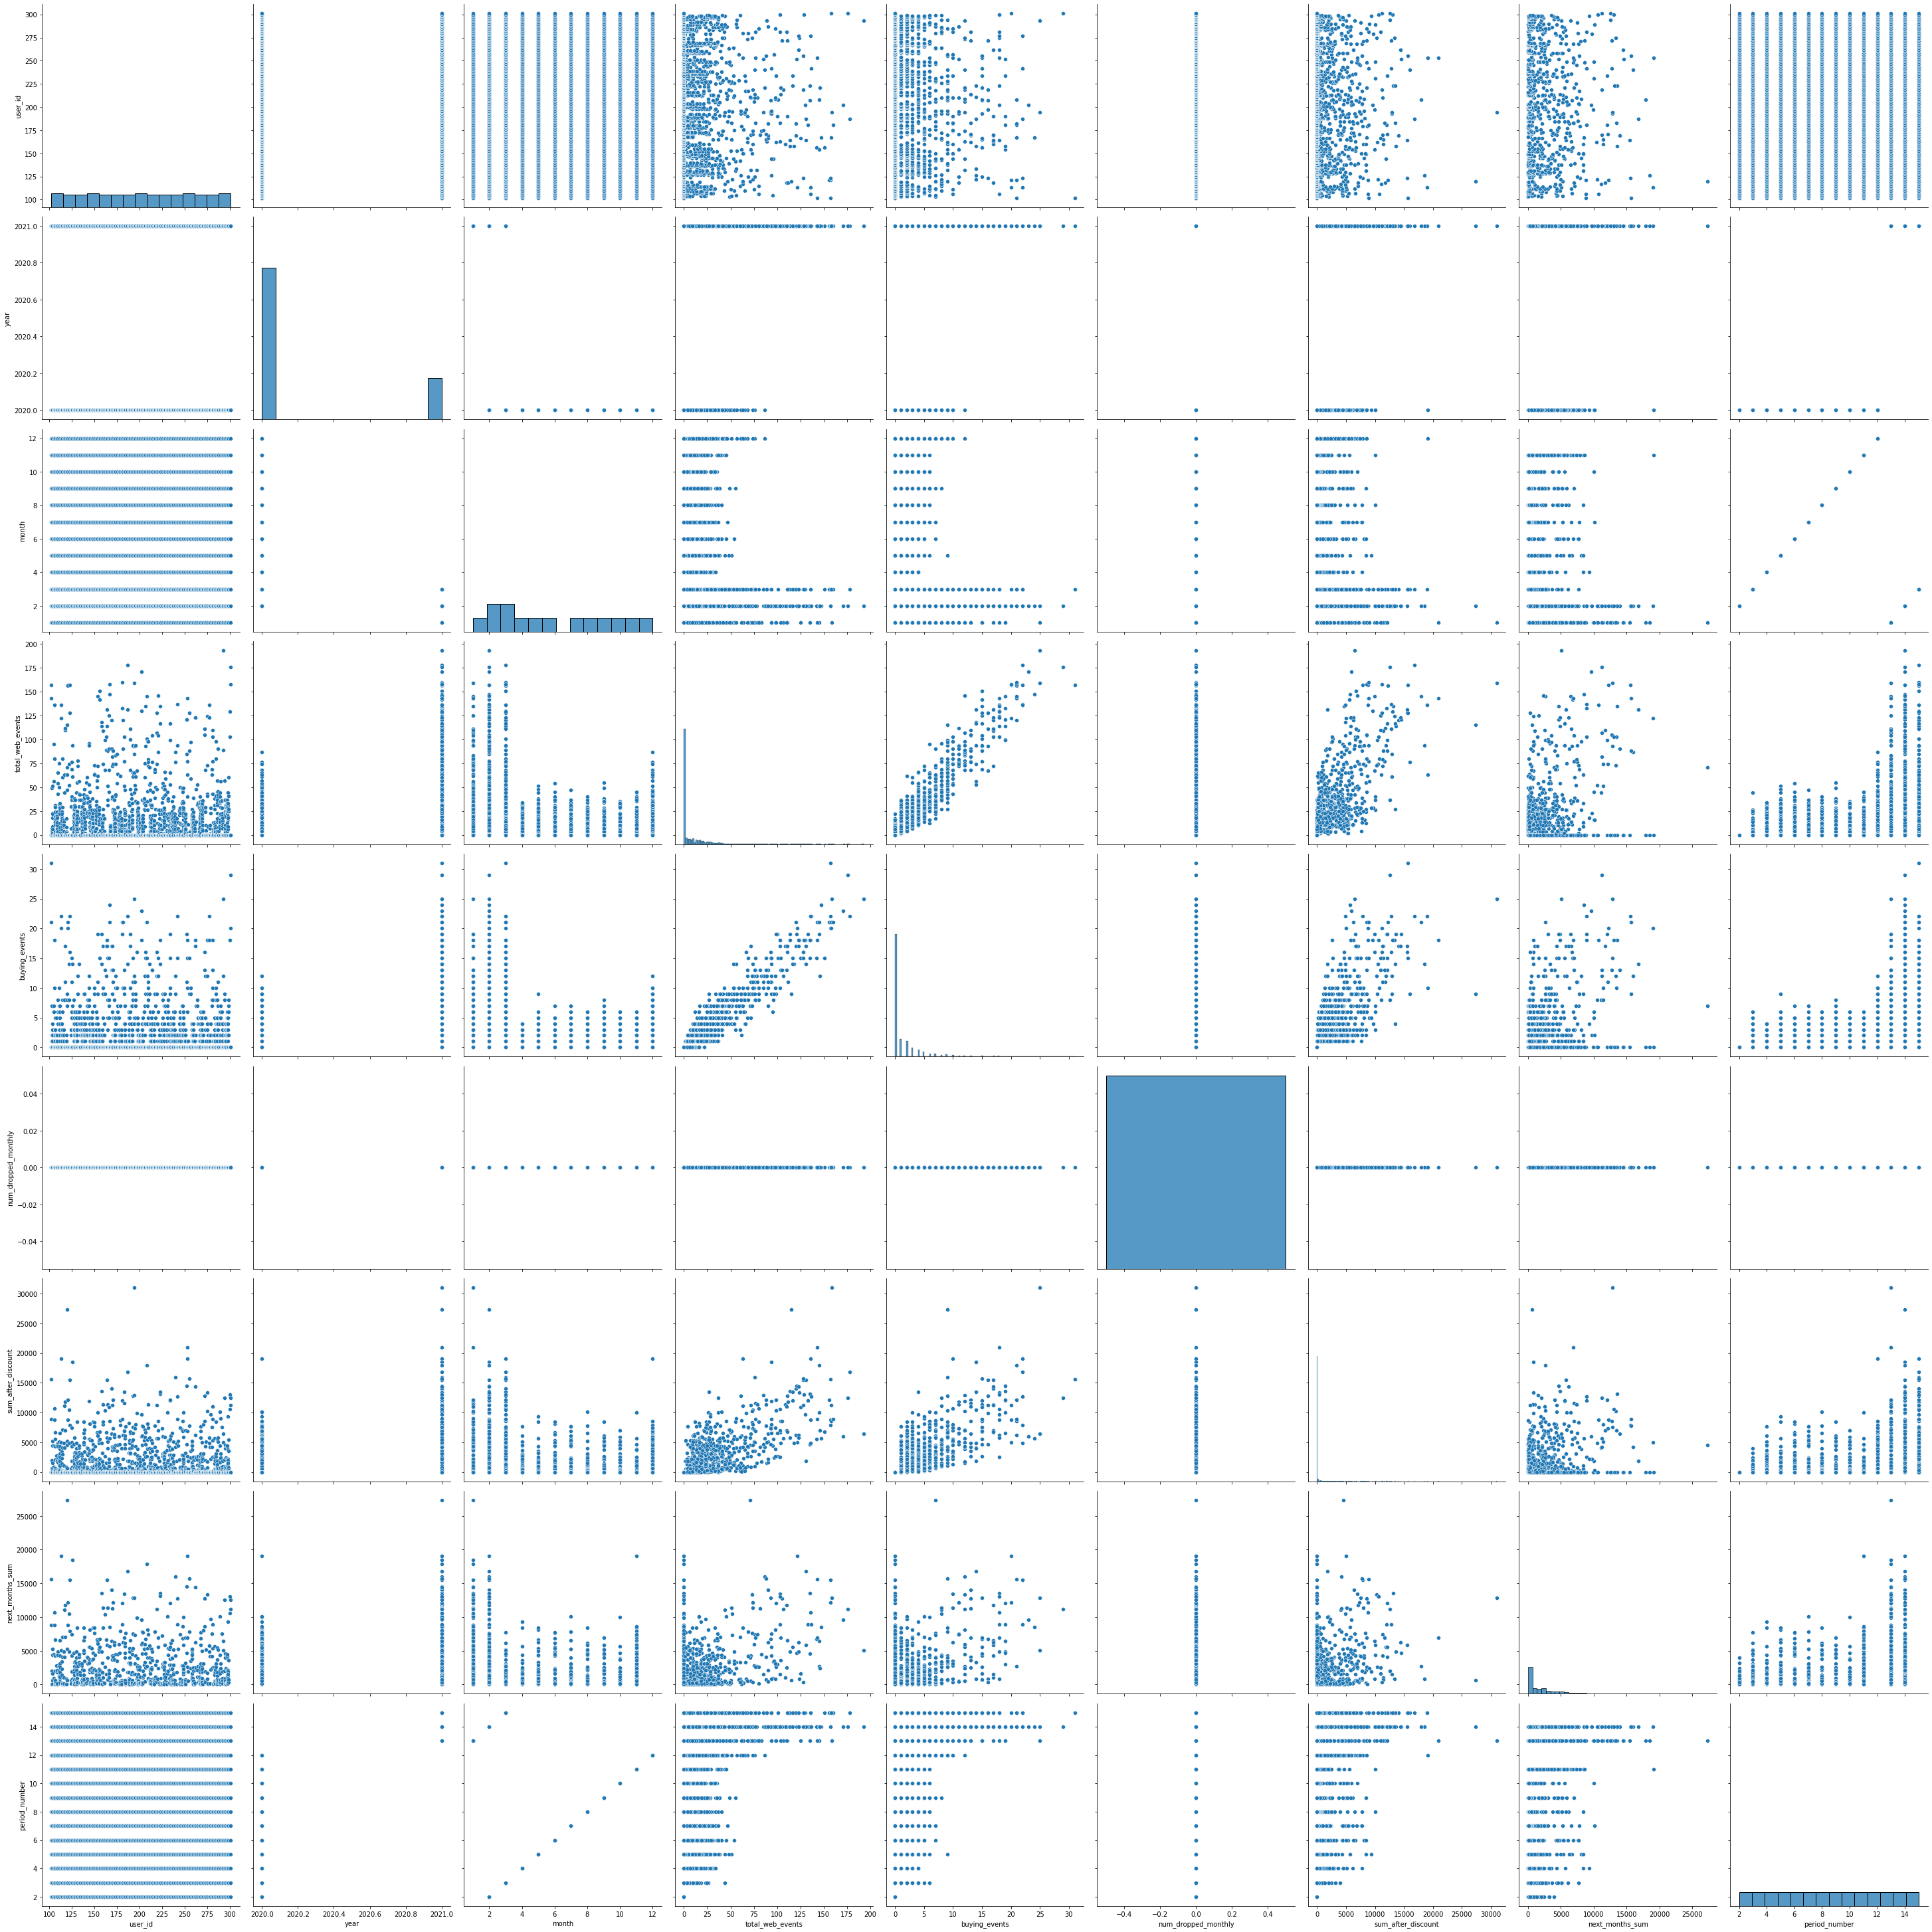

In [118]:
processed_data_with_period_number = processed_data.copy()
processed_data_with_period_number['period_number'] = ((processed_data_with_period_number['year'] - 2020) * 12) + processed_data_with_period_number['month']
processed_data_with_period_number['period_number']
processed_data_with_period_number.drop(columns=['month', 'year'])
sns.pairplot(processed_data_with_period_number, size=4.5)
plt.tight_layout()
plt.show()
# wyjście - przedostatni wiersz / kolumna

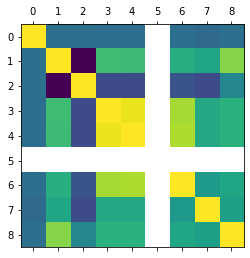

,user_id,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum,period_number
user_id,1.000000e+00,1.089908e-12,-7.387545e-16,-0.014174,-0.014642,NaN,-0.014417,-0.038450,-1.739382e-15
year,1.089908e-12,1.000000e+00,-5.871589e-01,0.506264,0.503503,NaN,0.405819,0.345871,7.125253e-01
month,-7.387545e-16,-5.871589e-01,1.000000e+00,-0.218298,-0.219307,NaN,-0.172029,-0.219273,1.495974e-01
total_web_events,-1.417440e-02,5.062645e-01,-2.182975e-01,1.000000,0.955395,NaN,0.785049,0.373533,4.291686e-01
buying_events,-1.464222e-02,5.035029e-01,-2.193068e-01,0.955395,1.000000,NaN,0.804637,0.367811,4.249206e-01
num_dropped_monthly,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_after_discount,-1.441719e-02,4.058190e-01,-1.720292e-01,0.785049,0.804637,NaN,1.000000,0.271071,3.465824e-01
next_months_sum,-3.845001e-02,3.458715e-01,-2.192734e-01,0.373533,0.367811,NaN,0.271071,1.000000,3.092545e-01
period_number,-1.739382e-15,7.125253e-01,1.495974e-01,0.429169,0.424921,NaN,0.346582,0.309254,1.000000e+00


In [119]:
plt.matshow(processed_data_with_period_number.corr())
plt.show()
processed_data_with_period_number.corr()

Zarówno z wykresów zależnośc między atrybutami jak i z korelacji widać, że otrzymany przez nas model nie jest modelem liniowym. Należy zatem albo zastosować bardziej skomplikowany model, albo poszukać innych atrybutów.